# Introduction
- This SERIES of notebooks aims to generate a posterior probability of inclusion for each article in the test set.
- In this notebook, We will first use the pure counts to generate likelihood ratios for each term inc:ex
- We can calculate a pvalue for each term using chi sq or Fishers exact to see if they reach significance which could be used to filter the terms used in our scoring
- We can also use the 95% Confidence intervals for the likelihood ratios to find terms with a clear boundary (ratio that doesnt cross 1)
- Those terms that are enriched in either the include or excluded set are brought forward as conditionals.
- The conditionals are then included to modify the prior probability of inclusion.

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pickle
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt

count_df = pickle.load(open('./improved_token_count_df.p', 'rb'))
ctrl_df = pickle.load(open('./sev_ctrl_token_count_df.p', 'rb'))

In [2]:
ctrl_df.columns = ['pres_test', 'abs_test', 'pres_ctrl', 'abs_ctrl']

In [3]:
count_df.columns = ['pres_test', 'abs_test', 'pres_ctrl', 'abs_ctrl']

In [4]:
# now lets make a fishers exact pval
def fishers_exact(pres_test, abs_test, pres_ctrl, abs_ctrl):
    # we are using a laplacean correction to avoid infinity and 0 in our calculations
    # this is the equivalent of adding a documnet with all terms and an empty document to each class
#     pres_inc = count_df.loc[term, 'pres_inc'] +1
#     abs_inc = count_df.loc[term, 'abs_inc'] +1
#     pres_ex = count_df.loc[term, 'pres_ex'] +1
#     abs_ex = count_df.loc[term, 'abs_ex'] +1
    
    
    pres_test +=1
    abs_test +=1
    pres_ctrl +=1
    abs_ctrl +=1
    
    table = np.array([[pres_test, abs_test],[pres_ctrl, abs_ctrl]])

    OR, pval = scipy.stats.fisher_exact(table, alternative='two-sided')
    
    pval = np.format_float_scientific(pval, exp_digits=3, precision=3, pad_left=3)
    
    return pval




def bonferoni(pval_vec):
    pval_vec = [float(pval) for pval in pval_vec]
    pval_vec = np.asarray(pval_vec)
    # set the original alpha (sig at <0.05)
    alpha = 0.05
    # assign output variables from correction test, apply test on pval vec
    reject_null_vec, corr_pval_vec, sidak, new_alpha = smm.multipletests(pval_vec, alpha=alpha, method='bonferroni')
    # assign the corrected pval vectore to the df
    corr_pval_vec = [np.format_float_scientific(pval, precision=3, exp_digits=2, pad_left=3) for pval in corr_pval_vec]
    
    return corr_pval_vec, reject_null_vec, new_alpha

def get_LR(term, df):
    
    # we need the number of included and excluded artilces in our training set
    # we can get that from summation of include present and absent for any term
    test_art_count = df['pres_test'][0] + df['pres_ctrl'][0]
    ctrl_art_count = df['abs_test'][0] + df['abs_ctrl'][0]
    
    ############## NB to remove infinite and neg infinte values when converting to Likelihood ratios #############
    # I am smoothing the count dataframe by adding two imagined documents, 
    # one with all terms and another which is empty - so called Laplacean smoothing
    # this practically means adding a count of 1 to every term and adding two document counts to each class

    # to make a likelihood ratio, we'll first calculate the likelihood (p_inc, p_ex) for each term for each class 
    L_inc = (df.loc[term, 'pres_test'] + 1) / (test_art_count + 2)
    L_ex = (df.loc[term, 'pres_ctrl'] + 1) / (ctrl_art_count +2)
    LR = L_inc/L_ex
    return LR

# One concern is about the credence paid to tokens with low counts
# this should be reflected by wide confidence intervals for the LR/OR
# we want to get the 95% CI for the OR - to do this we need the standard error
# now lets calculate the standard error of the log OR

def get_95_CI_LR(term, df):
    
    #print(term)
    pres_test, abs_test, pres_ctrl, abs_ctrl = df.loc[term, 'pres_test':'abs_ctrl'] +1
    
    #print(pres_inc, abs_inc, pres_ex, abs_ex)
    LR = df.loc[term, 'LR']
    ln_LR = np.log(LR)
    
    SE_ln_LR = np.sqrt((1/pres_test) + (1/abs_test) + (1/pres_ctrl) + (1/abs_ctrl))
    # print(SE_ln_OR)

    UCI = np.exp(ln_LR + (1.96*SE_ln_LR))
    #print(UCI)
    LCI = np.exp(ln_LR - (1.96*SE_ln_LR))
    #print(LCI)
    #print(f'\nWeighted OR with 95% CI for \"{term}\" = {np.round(OR,2)} ({np.round(LCI,2)}-{np.round(UCI,2)})')
    
    return tuple((np.round(LCI,3), np.round(UCI,3)))

# another way to subset is to choose only the terms whose 95% CI does not cross 1
def check_clear_CI(LCI_UCI):
    # using the biggest and smallest values for the LCI and UCI we can see if 1 falls between these values
    return not min(LCI_UCI) < 1 < max(LCI_UCI)

In [5]:


# apply the function to each term in our count_df
fe_pvals = []
for index, row in count_df.iterrows():
    fe_pvals.append(fishers_exact(row['pres_test'], row['abs_test'], row['pres_ctrl'],row['abs_ctrl']))
    
corr_pval_vec, reject_null_vec, new_alpha = bonferoni(fe_pvals)    

LRs = [get_LR(term, count_df) for term in count_df.index]

count_df['fe_pval'] = fe_pvals
count_df['reject_null'] = reject_null_vec
count_df['corr_pval'] = corr_pval_vec
count_df['LR'] = LRs



ci_vec = [get_95_CI_LR(term, count_df) for term in count_df.index]
count_df['LR_LCI_UCI'] = ci_vec


count_df['clear_CI'] = count_df['LR_LCI_UCI'].apply(check_clear_CI)


In [6]:


# apply the function to each term in our count_df
fe_pvals = []
for index, row in ctrl_df.iterrows():
    fe_pvals.append(fishers_exact(row['pres_test'], row['abs_test'], row['pres_ctrl'],row['abs_ctrl']))
    
corr_pval_vec, reject_null_vec, new_alpha = bonferoni(fe_pvals)    

LRs = [get_LR(term, ctrl_df) for term in ctrl_df.index]

ctrl_df['fe_pval'] = fe_pvals
ctrl_df['reject_null'] = reject_null_vec
ctrl_df['corr_pval'] = corr_pval_vec
ctrl_df['LR'] = LRs



ci_vec = [get_95_CI_LR(term, ctrl_df) for term in ctrl_df.index]
ctrl_df['LR_LCI_UCI'] = ci_vec


ctrl_df['clear_CI'] = ctrl_df['LR_LCI_UCI'].apply(check_clear_CI)

In [7]:
test_ci_df = count_df[count_df['clear_CI'] == True]
ctrl_ci_df = ctrl_df[ctrl_df['clear_CI']== True]

ci_enrichments = {}
for index, row in test_ci_df.iterrows():
    if index in ctrl_ci_df.index:
        ci_enrichments.update({index:{'test':row['LR'], 'ctrl':ctrl_df.loc[index, 'LR'], 'count':row['pres_test']}})

In [8]:
len(ci_enrichments)

563

In [9]:
test_sig_df = count_df[count_df['reject_null'] == True]
print(f'There are {len(test_sig_df)} terms out of a possible {len(count_df)} that reach significant enrichement after bonf correction')

There are 120 terms out of a possible 835 that reach significant enrichement after bonf correction


In [10]:
ctrl_sig_df = ctrl_df[ctrl_df['reject_null'] == True]
print(f'There are {len(ctrl_sig_df)} terms out of a possible {len(ctrl_df)} that reach significant enrichment')

There are 55 terms out of a possible 721 that reach significant enrichment


In [11]:
# for term in test_sig_df.index:
#     if term in ctrl_sig_df.index:
#         print(term)

In [12]:
enrichments = {}
for index, row in test_sig_df.iterrows():
    if index in ctrl_sig_df.index:
        enrichments.update({index:{'test':row['LR'], 'ctrl':ctrl_df.loc[index, 'LR']}})

In [17]:
test_sig_df

,pres_test,abs_test,pres_ctrl,abs_ctrl,fe_pval,reject_null,corr_pval,LR,LR_LCI_UCI,clear_CI
Abnormal B-type natriuretic peptide level,31,519,8,1114,2.561e-009,True,2.138e-06,346.980392,"(164.425, 732.219)",True
Abnormal amniotic fluid,2,548,45,1077,8.722e-006,True,7.283e-03,6.364450,"(1.971, 20.556)",True
Abnormal cardiac MRI,72,478,44,1078,3.842e-011,True,3.208e-08,158.309804,"(107.534, 233.061)",True
Abnormal corpus callosum morphology,22,528,6,1116,9.259e-007,True,7.731e-04,320.647059,"(136.726, 751.978)",True
Abnormal delivery,11,539,144,978,5.654e-015,True,4.721e-12,8.076268,"(4.441, 14.687)",True
...,...,...,...,...,...,...,...,...,...,...
Throwing up,232,318,202,920,4.223e-025,True,3.526e-22,112.010142,"(89.244, 140.584)",True
Tricuspid valve regurgitation,22,528,7,1115,2.49e-006,True,2.079e-03,280.566176,"(124.671, 631.399)",True
Vasculitis,46,504,31,1091,9.145e-007,True,7.636e-04,143.332721,"(90.355, 227.373)",True
Wet lung,27,523,13,1109,6.981e-006,True,5.829e-03,195.176471,"(101.9, 373.837)",True


In [18]:
low_enrichments = {}
for index, row in test_sig_df.iterrows():
    if index in ctrl_sig_df.index:
        low_enrichments.update({index:{'test':row['LR_LCI_UCI'][0], 'ctrl':ctrl_df.loc[index, 'LR_LCI_UCI'][0]}})

In [20]:
# x and y given as array_like objects
import plotly.express as px

df = pd.DataFrame.from_dict(low_enrichments, orient = 'index')
df.sort_values(by = 'test', ascending = False, inplace = True)
df = df.head(40)
df['Term'] = df.index

xlabel = "Enrichment for Severe over mild/mod COVID"
ylabel = "Enrichment COVID over PICU"

fig = px.scatter(df, x="test", y="ctrl", labels = {"ctrl":ylabel, "test":xlabel},hover_data = ['Term'], title = 'Severe COVID HPO Enrichment')



fig.write_html("low_CI_sev_vs_picu_ci_enrichment_fig.html")

In [13]:
keys = [key for key in enrichments.keys()]

In [15]:
df = pd.DataFrame.from_dict(enrichments, orient = 'index')
df['Term'] = df.index
df.head()

,test,ctrl,Term
Abnormal cardiac MRI,158.309804,74.703333,Abnormal cardiac MRI
Abnormal echocardiography,250.199625,127.563793,Abnormal echocardiography
Abnormal inflammatory response,163.563380,48.069737,Abnormal inflammatory response
Abnormal systemic blood pressure,105.974724,38.100893,Abnormal systemic blood pressure
Abnormal thrombosis,201.472486,89.309091,Abnormal thrombosis


In [16]:
df = pd.DataFrame.from_dict(ci_enrichments, orient = 'index')
df['Term'] = df.index
df.head()

,test,ctrl,count,Term
Abnormal QT interval,60.572008,23.025000,35,Abnormal QT interval
Abnormal amniotic fluid,6.364450,9.210000,2,Abnormal amniotic fluid
Abnormal bleeding,79.516340,30.700000,21,Abnormal bleeding
Abnormal cardiac MRI,158.309804,74.703333,72,Abnormal cardiac MRI
Abnormal cardiac catheterization,111.529412,122.800000,7,Abnormal cardiac catheterization


In [15]:
# x and y given as array_like objects
import plotly.express as px

df = pd.DataFrame.from_dict(ci_enrichments, orient = 'index')
df.sort_values(by = 'count', ascending = False, inplace = True)
df = df.head(30)
df['Term'] = df.index

xlabel = "Enrichment for Severe over mild/mod COVID"
ylabel = "Enrichment COVID over PICU"

fig = px.scatter(df, x="test", y="ctrl", labels = {"ctrl":ylabel, "test":xlabel},hover_data = ['Term'], title = 'Severe COVID HPO Enrichment')



fig.write_html("most_common_sev_vs_picu_ci_enrichment_fig.html")

In [18]:
# x and y given as array_like objects
import plotly.express as px

df = pd.DataFrame.from_dict(ci_enrichments, orient = 'index')
df = df[df['count'] > 20]
df.sort_values(by = 'test', ascending = False, inplace = True)
df = df.head(30)
df['Term'] = df.index

xlabel = "Enrichment for Severe over mild/mod COVID"
ylabel = "Enrichment COVID over PICU"

fig = px.scatter(df, x="test", y="ctrl", labels = {"ctrl":ylabel, "test":xlabel},hover_data = ['Term'], title = 'Severe COVID HPO Enrichment')



fig.write_html("min_ten_sev_vs_picu_ci_enrichment_fig.html")

In [24]:

df = pd.DataFrame.from_dict(ci_enrichments, orient = 'index')
df = df[df['count'] > 20]
df.sort_values(by = 'test', ascending = False, inplace = True)
df.head(30)

,test,ctrl,count
Coronary artery dilatation,591.628676,248.158333,96
Hypoalbuminaemia,517.968326,211.830000,68
Impaired left ventricular function,372.055147,312.116667,60
Cardiovascular shock,369.441176,271.183333,52
Mitral regurgitation,357.823529,168.850000,43
Aneurysms,351.317647,157.885714,71
Fluid around heart,346.980392,184.200000,95
Cervical lymphadenopathy,341.558824,80.587500,41
Cardiomegaly,337.122995,116.660000,37
Hyponatremia,328.251337,81.135714,36


In [23]:
# x and y given as array_like objects
import plotly.express as px

df = pd.DataFrame.from_dict(enrichments, orient = 'index')
df['Term'] = df.index

fig = px.scatter(df, x="test", y="ctrl", hover_data = ['Term'], title = 'Severe COVID HPO Enrichment')

xlabel = "Enrichment for Severe over mild/mod COVID"
ylabel = "Enrichment COVID over PICU"

fig.write_html("sev_vs_picu_enrichment_fig.html")

ValueError: Value of 'hover_data_1' is not the name of a column in 'data_frame'. Expected one of ['test', 'ctrl', 'Term'] but received: count

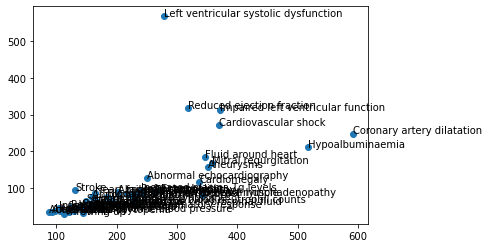

In [24]:
X = []
Y = []
for term, values in ci_enrichments.items():
    X.append(values['test'])
    Y.append(values['ctrl'])

labels = list(enrichments.keys())


fig, ax = plt.subplots()
ax.scatter(X,Y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (X[i], Y[i]))


In [29]:
sig_df.head()

,pres_test,abs_test,pres_ctrl,abs_ctrl,fe_pval,reject_null,corr_pval,LR,LR_LCI_UCI,clear_CI
Abnormal B-type natriuretic peptide level,31,519,8,1114,2.561e-009,True,2.138e-06,346.980392,"(164.425, 732.219)",True
Abnormal amniotic fluid,2,548,45,1077,8.722e-006,True,7.283e-03,6.364450,"(1.971, 20.556)",True
Abnormal cardiac MRI,72,478,44,1078,3.842e-011,True,3.208e-08,158.309804,"(107.534, 233.061)",True
Abnormal corpus callosum morphology,22,528,6,1116,9.259e-007,True,7.731e-04,320.647059,"(136.726, 751.978)",True
Abnormal delivery,11,539,144,978,5.654e-015,True,4.721e-12,8.076268,"(4.441, 14.687)",True


In [30]:
pickle.dump(sig_df, open('./sev_mild_sig_df.p', 'wb'))

# Making a term enrichment Plot

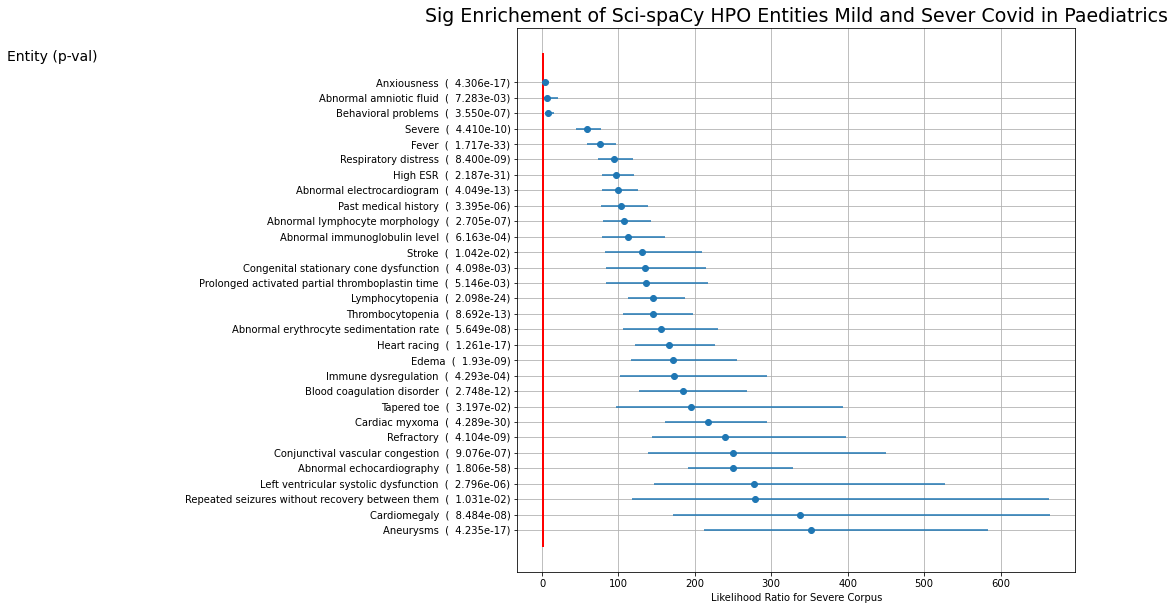

In [32]:
title = f'Sig Enrichement of Sci-spaCy HPO Entities Mild and Sever Covid in Paediatrics'
xlab_text = f'Likelihood Ratio for Severe Corpus'
xscale = 'linear'
file_name = f'./binary_ent_enrichement.png'


if len(sig_df) >= 30:
#     plot_df = sig_df.sample(30, random_state=2)
#     plot_df = sig_df.sort_values(by = 'corr_pval').head(30)
    high_df = sig_df.sort_values(by='LR', ascending = False).head(60)
    low_df = sig_df.sort_values(by='LR', ascending = True).head(60)
    plot_df = pd.concat([high_df, low_df])
    plot_df = plot_df.sample(30)
    plot_df.sort_values(by = 'LR', ascending = False, inplace = True)
else:
    plot_df = sig_df
    plot_df.sort_values(by = 'LR', ascending = False, inplace = True)

# to make our plot we will need to use the UCI and LCI to make error bars

error_bar_vec = [] 
LCI_vec = []
UCI_vec = []

for index, row in plot_df.iterrows():
    LR = row['LR']
    LCI_vec.append(LR - row['LR_LCI_UCI'][0])
    UCI_vec.append(row['LR_LCI_UCI'][1] - LR)

error_bar_vec.append(LCI_vec)
error_bar_vec.append(UCI_vec)
    
error_bar_vec = np.asarray(error_bar_vec)


# we'll also need the pvalues associated with each term
# pvals = [np.format_float_scientific(pval, precision=3, exp_digits=2) for pval in plot_df['corr_pval']]
pvals = plot_df['corr_pval']
term_vec = zip(plot_df.index,pvals)
y_strings = []
for a, b in term_vec:
    y_strings.append(f'{a}  ({b})')
    
    
# Create a list of vectors for use in a plot and round to 2 decimal places
term_vec = y_strings
OR_vec = plot_df.LR
error_bar_vec = error_bar_vec
y = np.arange(0.1, len(plot_df), 1)
x = OR_vec



fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(111)
plt.title(title, fontsize = 19)
plt.errorbar(x, y, xerr=error_bar_vec, fmt='o')
plt.xlabel(xlab_text)
ax1.text(-700, len(plot_df)+0.5, 'Entity (p-val)', fontsize=14)
plt.xscale(xscale)
plt.yticks(y, labels=term_vec, ha='right')
plt.vlines(ymin=-1, ymax=len(plot_df)+1, x = 1, linewidth=2.0, color="red")
plt.grid(True)

# plt.savefig(file_name, dpi=300, format='png', bbox_inches='tight' )
plt.show()



In [48]:
count_df.loc['Cardiac myxoma',:]

pres_sev      155
abs_sev       395
pres_mild      69
abs_mild     1053
Name: Cardiac myxoma, dtype: int64

In [54]:
ci_df = count_df[count_df['clear_CI'] == True]
print(f'There are {len(ci_df)} terms out of a possible {len(count_df)} that have clear confidence intervals')

There are 831 terms out of a possible 835 that have clear confidence intervals


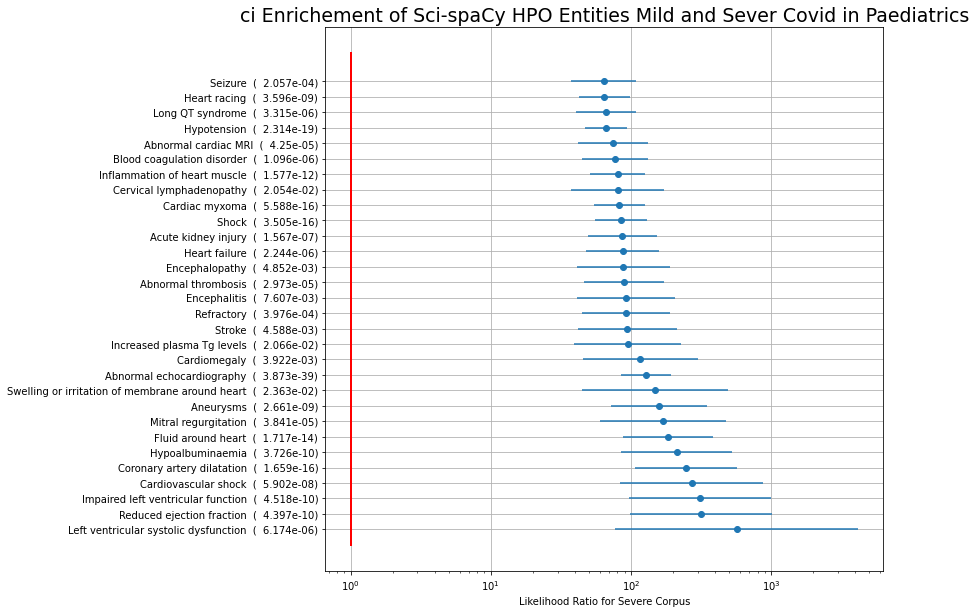

In [71]:
title = f'ci Enrichement of Sci-spaCy HPO Entities Mild and Sever Covid in Paediatrics'
xlab_text = f'Likelihood Ratio for Severe Corpus'
xscale = 'log'
file_name = f'./binary_ent_enrichement.png'


plot_df = sig_df.sort_values(by='LR', ascending = False)
plot_df = plot_df.head(30)


# to make our plot we will need to use the UCI and LCI to make error bars

error_bar_vec = [] 
LCI_vec = []
UCI_vec = []

for index, row in plot_df.iterrows():
    LR = row['LR']
    LCI_vec.append(LR - row['LR_LCI_UCI'][0])
    UCI_vec.append(row['LR_LCI_UCI'][1] - LR)

error_bar_vec.append(LCI_vec)
error_bar_vec.append(UCI_vec)
    
error_bar_vec = np.asarray(error_bar_vec)


# we'll also need the pvalues associated with each term
# pvals = [np.format_float_scientific(pval, precision=3, exp_digits=2) for pval in plot_df['corr_pval']]
pvals = plot_df['corr_pval']
term_vec = zip(plot_df.index,pvals)
y_strings = []
for a, b in term_vec:
    y_strings.append(f'{a}  ({b})')
    
    
# Create a list of vectors for use in a plot and round to 2 decimal places
term_vec = y_strings
OR_vec = plot_df.LR
error_bar_vec = error_bar_vec
y = np.arange(0.1, len(plot_df), 1)
x = OR_vec



fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(111)
plt.title(title, fontsize = 19)
plt.errorbar(x, y, xerr=error_bar_vec, fmt='o')
plt.xlabel(xlab_text)
# ax1.text(-700, len(plot_df)+0.5, 'Entity (p-val)', fontsize=14)
plt.xscale(xscale)
plt.yticks(y, labels=term_vec, ha='right')
plt.vlines(ymin=-1, ymax=len(plot_df)+1, x = 1, linewidth=2.0, color="red")
plt.grid(True)

# plt.savefig(file_name, dpi=300, format='png', bbox_inches='tight' )
plt.show()



In [72]:
pickle.dump(count_df, open('./sev_mild_count_df.p', 'wb'))
pickle.dump(ctrl_df, open('./covid_picu_count_df.p', 'wb'))